In [32]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import joblib

def extract_central_rgb(image_path):
    image = Image.open(image_path)
    width, height = image.size
    central_pixel = image.getpixel((width // 2, height // 2))
    return central_pixel

def load_images_from_folder(folder_path,keyword):
    image_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') and filename.startswith(keyword):
            image_paths.append(os.path.join(folder_path, filename))
    return image_paths

keyword ='fixed'
folder_path = "C:/Users/USER/Desktop/pH/fixed/total1"
image_paths = load_images_from_folder(folder_path,keyword)

data = []

for image_path in image_paths:
    judge_value = 'error'
    # 이미지 파일 제목에서 pH 추출
    pH_value = os.path.splitext(os.path.basename(image_path))[0].split('_')[2]
    if (4.8<=float(pH_value)<=5.6):
        judge_value = 'danger'
    elif (5.7<=float(pH_value)<=6.0):
        judge_value = 'warning'
    elif (6.1<=float(pH_value)<=6.4):
        judge_value = 'safe'
        
    # 중앙 부분의 RGB 값을 추출
    rgb = extract_central_rgb(image_path)
    
    # 튜플로 데이터 생성
    image_data = (judge_value, pH_value, rgb[0], rgb[1], rgb[2])
    
    # 데이터 추가
    data.append(image_data)

# Extracting data for plotting
judge_values = [item[0] for item in data]
pH_values = [item[1] for item in data]
R_values = [item[2] for item in data]
G_values = [item[3] for item in data]
B_values = [item[4] for item in data]

for item in data:
    print(f"judge:{item[0]}, pH:{item[1]} - R:{item[2]}, G:{item[3]}, B:{item[4]}")
    
#data dataframe로 저장    
df = pd.DataFrame(data, columns=['judge','pH', 'R', 'G', 'B'])

# DataFrame을 Excel 파일로 저장
excel_filename = 'output_data.csv'
#df.to_excel(excel_filename, index=False)
df.to_csv(excel_filename, index=False)

df.isnull().sum()

pd.get_dummies(df['judge'])

# DataFrame을 섞습니다.
df_shuffled = shuffle(df, random_state=42)

# 데이터를 훈련, 검증, 테스트 세트로 나눕니다.
train_size = 0.6  # 훈련에 60% 할당
valid_size = 0.2  # 검증에 20% 할당, 나머지 20%는 테스트에 할당됩니다.

train, temp = train_test_split(df_shuffled, train_size=train_size, random_state=42)
valid, test = train_test_split(temp, test_size=valid_size / (1 - train_size), random_state=42)

# 각 세트에 대해 독립 변수 (X)와 종속 변수 (y)를 분리합니다.
X_train, y_train = train[['R', 'G', 'B']], train['judge']
X_valid, y_valid = valid[['R', 'G', 'B']], valid['judge']
X_test, y_test = test[['R', 'G', 'B']], test['judge']

'''# 결과를 출력합니다.
print("훈련 데이터셋:\n", X_train, "\n", y_train)
print("\n검증 데이터셋:\n", X_valid, "\n", y_valid)
print("\n테스트 데이터셋:\n", X_test, "\n", y_test)'''

# RobustScaler를 사용하여 데이터 정규화
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.transform(X_test)
X_valid_robust = rbs.transform(X_valid) 

# SVM 모델 생성
svm = SVC(random_state=42)

# 탐색할 하이퍼파라미터 값들 지정
param_grid_svm = {
    'C': [40],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train_robust, y_train)

# 최적의 하이퍼파라미터 확인
best_params_svm = grid_search_svm.best_params_
'''print("최적의 하이퍼파라미터:", best_params_svm)'''

# 최적의 모델로 예측 수행
best_svm = grid_search_svm.best_estimator_
y_pred_tuned_svm = best_svm.predict(X_test_robust)

'''# 튜닝된 모델의 정확도 확인
accuracy_tuned_svm = accuracy_score(y_test, y_pred_tuned_svm)
print("튜닝된 모델의 정확도:", accuracy_tuned_svm)

# 다른 평가 지표 출력 (정밀도, 재현율, F1 스코어)
print("분류 보고서:\n", classification_report(y_test, y_pred_tuned_svm))

# 검증 데이터로 정확도 평가
y_pred_valid_svm = best_svm.predict(X_valid_robust)
accuracy_valid_svm = accuracy_score(y_valid, y_pred_valid_svm)
print("최적 모델의 검증 정확도:", accuracy_valid_svm)

# 테스트 데이터로 정확도 평가
y_pred_test_svm = best_svm.predict(X_test_robust)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)
print("최적 모델의 테스트 정확도:", accuracy_test_svm)'''

# 모델 저장
model_filename = 'best_svm.joblib'
joblib.dump(best_svm, model_filename)
print(f"모델이 {model_filename}로 저장되었습니다.")


judge:error, pH:4.0 - R:117, G:119, B:79
judge:error, pH:4.0 - R:113, G:121, B:82
judge:error, pH:4.0 - R:110, G:112, B:75
judge:error, pH:4.0 - R:112, G:121, B:90
judge:error, pH:4.0 - R:110, G:116, B:82
judge:error, pH:4.0 - R:109, G:110, B:70
judge:error, pH:4.0 - R:115, G:116, B:74
judge:error, pH:4.0 - R:112, G:118, B:82
judge:error, pH:4.0 - R:114, G:120, B:76
judge:error, pH:4.0 - R:107, G:113, B:77
judge:error, pH:4.0 - R:109, G:114, B:74
judge:error, pH:4.0 - R:112, G:117, B:77
judge:error, pH:4.0 - R:112, G:118, B:84
judge:error, pH:4.0 - R:109, G:116, B:83
judge:error, pH:4.0 - R:115, G:117, B:80
judge:error, pH:4.0 - R:111, G:118, B:84
judge:error, pH:4.0 - R:106, G:115, B:84
judge:error, pH:4.0 - R:112, G:116, B:83
judge:error, pH:4.1 - R:107, G:112, B:72
judge:error, pH:4.1 - R:110, G:121, B:91
judge:error, pH:4.1 - R:100, G:102, B:65
judge:error, pH:4.1 - R:108, G:112, B:79
judge:error, pH:4.1 - R:105, G:112, B:79
judge:error, pH:4.1 - R:102, G:108, B:70
judge:error, pH:

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import joblib

def extract_central_rgb(image_path):
    image = Image.open(image_path)
    width, height = image.size
    central_pixel = image.getpixel((width // 2, height // 2))
    return central_pixel

def load_images_from_folder(folder_path,keyword):
    image_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') and filename.startswith(keyword):
            image_paths.append(os.path.join(folder_path, filename))
    return image_paths

keyword ='fixed'
folder_path = "C:/Users/USER/Desktop/pH/fixed/total1"
image_paths = load_images_from_folder(folder_path,keyword)

data = []

for image_path in image_paths:
    judge_value = 'error'
    # 이미지 파일 제목에서 pH 추출
    pH_value = os.path.splitext(os.path.basename(image_path))[0].split('_')[2]
    if (4.8<=float(pH_value)<=5.6):
        judge_value = 'danger'
    elif (5.7<=float(pH_value)<=6.0):
        judge_value = 'warning'
    elif (6.1<=float(pH_value)<=6.4):
        judge_value = 'safe'
        
    # 중앙 부분의 RGB 값을 추출
    rgb = extract_central_rgb(image_path)
    
    # 튜플로 데이터 생성
    image_data = (judge_value, pH_value, rgb[0], rgb[1], rgb[2])
    
    # 데이터 추가
    data.append(image_data)

# Extracting data for plotting
judge_values = [item[0] for item in data]
pH_values = [item[1] for item in data]
R_values = [item[2] for item in data]
G_values = [item[3] for item in data]
B_values = [item[4] for item in data]
    
#data dataframe로 저장    
df = pd.DataFrame(data, columns=['judge','pH', 'R', 'G', 'B'])

# DataFrame을 Excel 파일로 저장
excel_filename = 'output_data.csv'
#df.to_excel(excel_filename, index=False)
df.to_csv(excel_filename, index=False)

df.isnull().sum()

pd.get_dummies(df['judge'])

# DataFrame을 섞습니다.
df_shuffled = shuffle(df, random_state=42)

# 데이터를 훈련, 검증, 테스트 세트로 나눕니다.
train_size = 0.6  # 훈련에 60% 할당
valid_size = 0.2  # 검증에 20% 할당, 나머지 20%는 테스트에 할당됩니다.

train, temp = train_test_split(df_shuffled, train_size=train_size, random_state=42)
valid, test = train_test_split(temp, test_size=valid_size / (1 - train_size), random_state=42)

# 각 세트에 대해 독립 변수 (X)와 종속 변수 (y)를 분리합니다.
X_train, y_train = train[['R', 'G', 'B']], train['judge']
X_valid, y_valid = valid[['R', 'G', 'B']], valid['judge']
X_test, y_test = test[['R', 'G', 'B']], test['judge']

# RobustScaler를 사용하여 데이터 정규화
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.transform(X_test)
X_valid_robust = rbs.transform(X_valid) 

# SVM 모델 생성
svm = SVC(random_state=42)

# 탐색할 하이퍼파라미터 값들 지정
param_grid_svm = {
    'C': [40],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train_robust, y_train)

# 최적의 하이퍼파라미터 확인
best_params_svm = grid_search_svm.best_params_
'''print("최적의 하이퍼파라미터:", best_params_svm)'''

# 최적의 모델로 예측 수행
best_svm = grid_search_svm.best_estimator_
y_pred_tuned_svm = best_svm.predict(X_test_robust)

# 모델 저장
model_filename = 'best_svm.joblib'
joblib.dump(best_svm, model_filename)
print(f"모델이 {model_filename}로 저장되었습니다.")


모델이 best_svm.joblib로 저장되었습니다.


4.0<=pH_value<=4.7
judge_value = 'error'
4.8<=pH_value<=5.6
judge_value = 'danger'
5.7<=pH_value<=6.0
judge_value = 'warning'
6.1<=pH_value<=6.4
judge_value = 'safe'

### 4.1 누락된 데이터 다루기 

In [4]:
#누락된 값의 개수를 확인하기 
df.isnull().sum()

judge    0
pH       0
R        0
G        0
B        0
dtype: int64

### 4.2 OneHotEncoding (pandas -> get_dummies)

In [5]:
pd.get_dummies(df['judge'])

,danger,error,safe,warning
0,False,True,False,False
1,False,True,False,False
2,False,True,False,False
3,False,True,False,False
4,False,True,False,False
...,...,...,...,...
210,False,False,True,False
211,False,False,True,False
212,False,False,True,False
213,False,False,True,False


### 4.3 데이터를 학습, 검증, 평가로 분리 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd

# DataFrame을 섞습니다.
df_shuffled = shuffle(df, random_state=42)

# 데이터를 훈련, 검증, 테스트 세트로 나눕니다.
train_size = 0.6  # 훈련에 60% 할당
valid_size = 0.2  # 검증에 20% 할당, 나머지 20%는 테스트에 할당됩니다.

train, temp = train_test_split(df_shuffled, train_size=train_size, random_state=42)
valid, test = train_test_split(temp, test_size=valid_size / (1 - train_size), random_state=42)

# 각 세트에 대해 독립 변수 (X)와 종속 변수 (y)를 분리합니다.
X_train, y_train = train[['R', 'G', 'B']], train['judge']
X_valid, y_valid = valid[['R', 'G', 'B']], valid['judge']
X_test, y_test = test[['R', 'G', 'B']], test['judge']

# 결과를 출력합니다.
print("훈련 데이터셋:\n", X_train, "\n", y_train)
print("\n검증 데이터셋:\n", X_valid, "\n", y_valid)
print("\n테스트 데이터셋:\n", X_test, "\n", y_test)


훈련 데이터셋:
        R    G    B
189   75   69   97
164   75   70  100
4    113  119   83
0    117  119   80
138   84   81  100
..   ...  ...  ...
209   84   83  114
67    96  108   94
46    92  106   89
174   77   78   98
141   77   75   96

[129 rows x 3 columns] 
 189       safe
164    warning
4        error
0        error
138    warning
        ...   
209       safe
67      danger
46       error
174    warning
141    warning
Name: judge, Length: 129, dtype: object

검증 데이터셋:
        R    G    B
33    97  107   80
54    96  104   80
153   74   82   93
154   78   78   90
74    89   98   81
27   105  116   84
17   101  111   84
150   86   85   99
159   86   86  110
3    110  119   88
163   74   76   97
213   74   69  101
199   73   67  105
192   75   69   97
51    94  108   85
63    78   79   65
58    94  106   86
171   78   79   97
48   101  112   95
144   73   64   85
187   79   64   97
26    96  105   76
22   107  114   83
182   75   76  104
147   78   76   90
101   84   94   86
68    9

### 4.4 특성 스케일 맞추기 

#### RubustScaler

In [7]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# RobustScaler를 사용하여 데이터 정규화
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.transform(X_test)
X_valid_robust = rbs.transform(X_valid) 

## Classification

## 모델 적용 및 평가 , 성능 끌어 올리기 


정밀도(Precision):
상황: 거짓 양성 비용이 높은 경우 (즉, 실제로 음성인데 양성으로 잘못 예측되는 경우)
목표: 모델의 양성 예측이 실제로 양성인 경우에 신뢰할 수 있도록 할 때 사용합니다.


재현율(Recall):
상황: 거짓 음성 비용이 높은 경우 (즉, 실제로 양성인데 음성으로 잘못 예측되는 경우)
목표: 모델이 모든 실제 양성 사례를 캡처하도록 하는 경우에 사용합니다.

F1 스코어:
상황: 정밀도와 재현율 사이에 균형이 필요한 경우, 특히 클래스 불균형이 심한 경우
목표: 정밀도와 재현율의 조화로운 평가를 원할 때 사용합니다. 클래스 간의 균형이 중요한 경우에 유용합니다.
데이터의 특성과 목표에 따라 적절한 지표를 선택해야 합니다. 
예를 들어, 의료 분야에서는 실제 양성을 놓치면 안 되므로 재현율이 중요할 수 있습니다. 
반면에 스팸 필터에서는 정밀도가 높아야 하므로 실제로 스팸이 아닌데 스팸으로 분류하는 경우를 최소화해야 할 것입니다.

서포트 :  지정된 데이터셋에서 클래스의 실제 발생 횟수입니다.
각 클래스의 샘플 수를 나타냅니다.


다양한 평가 지표를 함께 고려하는 것이 바람직.


### (1) KNN (KNeighborsClassifier)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# KNN 모델 생성
knn = KNeighborsClassifier()

# 탐색할 하이퍼파라미터 값들 지정
param_grid = {'n_neighbors': [5, 6, 7],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_robust, y_train)

# 최적의 하이퍼파라미터 확인
best_params = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params)

# 최적의 모델로 예측 수행
best_knn = grid_search.best_estimator_
y_pred_tuned = best_knn.predict(X_test_robust)

# 튜닝된 모델의 정확도 확인
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("튜닝된 모델의 정확도:", accuracy_tuned)

# 다른 평가 지표 출력 (정밀도, 재현율, F1 스코어)
print("분류 보고서:\n", classification_report(y_test, y_pred_tuned))


# 검증 데이터로 정확도 평가
y_pred_valid = best_knn.predict(X_valid_robust)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print("최적 모델의 검증 정확도:", accuracy_valid)

# 테스트 데이터로 정확도 평가
y_pred_test = best_knn.predict(X_test_robust)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("최적 모델의 테스트 정확도:", accuracy_test)


최적의 하이퍼파라미터: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
튜닝된 모델의 정확도: 0.9534883720930233
분류 보고서:
               precision    recall  f1-score   support

      danger       0.89      1.00      0.94        16
       error       1.00      0.93      0.96        14
        safe       1.00      1.00      1.00         7
     warning       1.00      0.83      0.91         6

    accuracy                           0.95        43
   macro avg       0.97      0.94      0.95        43
weighted avg       0.96      0.95      0.95        43

최적 모델의 검증 정확도: 0.8837209302325582
최적 모델의 테스트 정확도: 0.9534883720930233


### (2) Naive Bayes - GussianNB

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Naive Bayes 모델 생성
naive_bayes = GaussianNB()

# 모델 학습
naive_bayes.fit(X_train_robust, y_train)

# 테스트 데이터로 예측 수행
y_pred_test_naive_bayes = naive_bayes.predict(X_test_robust)

# 정확도 평가
accuracy_test_naive_bayes = accuracy_score(y_test, y_pred_test_naive_bayes)
print("Naive Bayes 모델의 테스트 정확도:", accuracy_test_naive_bayes)

# 다른 평가 지표 출력 (정밀도, 재현율, F1 스코어)
print("Naive Bayes 모델의 분류 보고서:\n", classification_report(y_test, y_pred_test_naive_bayes))


Naive Bayes 모델의 테스트 정확도: 0.6976744186046512
Naive Bayes 모델의 분류 보고서:
               precision    recall  f1-score   support

      danger       0.71      0.75      0.73        16
       error       0.71      0.71      0.71        14
        safe       0.80      0.57      0.67         7
     warning       0.57      0.67      0.62         6

    accuracy                           0.70        43
   macro avg       0.70      0.68      0.68        43
weighted avg       0.71      0.70      0.70        43



### (3) Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report

# Logistic Regression 모델 생성
logistic_regression = LogisticRegression(solver='liblinear')  # 'liblinear' solver 사용
# 또는
# logistic_regression = LogisticRegression(penalty='l2')  # 'l2' penalty 사용

# 탐색할 하이퍼파라미터 값들 지정
param_grid = {'C': [0.8, 0.9, 1],
              'penalty': ['l2']}  # 'l2' penalty 사용

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)
grid_search.fit(X_train_robust, y_train)

# 나머지 코드는 이전과 동일합니다.


# 최적의 하이퍼파라미터 확인
best_params = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params)

# 최적의 모델로 예측 수행
best_logistic_regression = grid_search.best_estimator_
y_pred_test_logistic_tuned = best_logistic_regression.predict(X_test_robust)

# 튜닝된 모델의 정확도 확인
accuracy_test_logistic_tuned = accuracy_score(y_test, y_pred_test_logistic_tuned)
print("튜닝된 Logistic Regression 모델의 테스트 정확도:", accuracy_test_logistic_tuned)

print("분류 보고서:\n", classification_report(y_test, y_pred_tuned, zero_division=1))

최적의 하이퍼파라미터: {'C': 0.9, 'penalty': 'l2'}
튜닝된 Logistic Regression 모델의 테스트 정확도: 0.813953488372093
분류 보고서:
               precision    recall  f1-score   support

      danger       0.89      1.00      0.94        16
       error       1.00      0.93      0.96        14
        safe       1.00      1.00      1.00         7
     warning       1.00      0.83      0.91         6

    accuracy                           0.95        43
   macro avg       0.97      0.94      0.95        43
weighted avg       0.96      0.95      0.95        43



### (4) RandomForest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Random Forest 모델 생성
rf = RandomForestClassifier(random_state=42)

# 탐색할 하이퍼파라미터 값들 지정
param_grid = {
    'n_estimators': [100],
    'max_depth': [6,7],
    'min_samples_split': [4, 5,6],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train_robust, y_train)

# 최적의 하이퍼파라미터 확인
best_params_rf = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params_rf)

# 최적의 모델로 예측 수행
best_rf = grid_search.best_estimator_
y_pred_tuned_rf = best_rf.predict(X_test_robust)

# 튜닝된 모델의 정확도 확인
accuracy_tuned_rf = accuracy_score(y_test, y_pred_tuned_rf)
print("튜닝된 모델의 정확도:", accuracy_tuned_rf)

# 다른 평가 지표 출력 (정밀도, 재현율, F1 스코어)
print("분류 보고서:\n", classification_report(y_test, y_pred_tuned_rf))

# 검증 데이터로 정확도 평가
y_pred_valid_rf = best_rf.predict(X_valid_robust)
accuracy_valid_rf = accuracy_score(y_valid, y_pred_valid_rf)
print("최적 모델의 검증 정확도:", accuracy_valid_rf)

# 테스트 데이터로 정확도 평가
y_pred_test_rf = best_rf.predict(X_test_robust)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
print("최적 모델의 테스트 정확도:", accuracy_test_rf)


최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
튜닝된 모델의 정확도: 0.9534883720930233
분류 보고서:
               precision    recall  f1-score   support

      danger       0.89      1.00      0.94        16
       error       1.00      0.93      0.96        14
        safe       1.00      1.00      1.00         7
     warning       1.00      0.83      0.91         6

    accuracy                           0.95        43
   macro avg       0.97      0.94      0.95        43
weighted avg       0.96      0.95      0.95        43

최적 모델의 검증 정확도: 0.9302325581395349
최적 모델의 테스트 정확도: 0.9534883720930233


### (6) Support Vector Machine

In [28]:
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# SVM 모델 생성
svm = SVC(random_state=42)

# 탐색할 하이퍼파라미터 값들 지정
param_grid_svm = {
    'C': [100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'gamma': ['scale'],
    'degree': [3]
}

# Compute the precomputed kernel matrix
K_train = pairwise_kernels(X_train_robust, metric='linear')
K_test = pairwise_kernels(X_test_robust, X_train_robust, metric='linear')
K_valid = pairwise_kernels(X_valid_robust, X_train_robust, metric='linear')

# Use the precomputed kernel matrix in GridSearchCV
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_search_svm.fit(K_train, y_train)

# Get the best parameters and the best model
best_params_svm = grid_search_svm.best_params_
print("Best Hyperparameters:", best_params_svm)

best_svm = grid_search_svm.best_estimator_

# Predictions on test and validation data
y_pred_tuned_svm = best_svm.predict(K_test)
y_pred_valid_svm = best_svm.predict(K_valid)

# Accuracy evaluation
accuracy_tuned_svm = accuracy_score(y_test, y_pred_tuned_svm)
accuracy_valid_svm = accuracy_score(y_valid, y_pred_valid_svm)

# Other evaluation metrics
print("Classification Report (Test):\n", classification_report(y_test, y_pred_tuned_svm))

print("Tuned Model Accuracy (Test):", accuracy_tuned_svm)
print("Tuned Model Accuracy (Validation):", accuracy_valid_svm)


Best Hyperparameters: {'C': 100, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report (Test):
               precision    recall  f1-score   support

      danger       0.94      0.94      0.94        16
       error       0.93      0.93      0.93        14
        safe       1.00      0.86      0.92         7
     warning       0.86      1.00      0.92         6

    accuracy                           0.93        43
   macro avg       0.93      0.93      0.93        43
weighted avg       0.93      0.93      0.93        43

Tuned Model Accuracy (Test): 0.9302325581395349
Tuned Model Accuracy (Validation): 0.9534883720930233


In [11]:
conda config --add channels conda-forge


Note: you may need to restart the kernel to use updated packages.


### 모델 저장 후 예측

In [29]:
import joblib

# 모델 저장
model_filename = 'knn_model.joblib'
joblib.dump(best_knn, model_filename)
print(f"모델이 {model_filename}로 저장되었습니다.")


모델이 knn_model.joblib로 저장되었습니다.


In [30]:
import joblib

# 모델 저장
model_filename = 'best_svm.joblib'
joblib.dump(best_svm, model_filename)
print(f"모델이 {model_filename}로 저장되었습니다.")

모델이 best_svm.joblib로 저장되었습니다.


In [33]:
# 저장된 모델 불러오기
loaded_model = joblib.load('best_svm.joblib')

r=input()
g=input()
b=input()
# 새로운 데이터에 대한 예측 수행
new_data = [[r, g, b]]  # 새로운 데이터의 RGB 값
new_data_robust = rbs.transform(new_data)  # 특성 스케일링

prediction = loaded_model.predict(new_data_robust)
print("예측 결과:", prediction)

50
50
50
예측 결과: ['error']


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


##### 시각화 : Plotting the RGB values

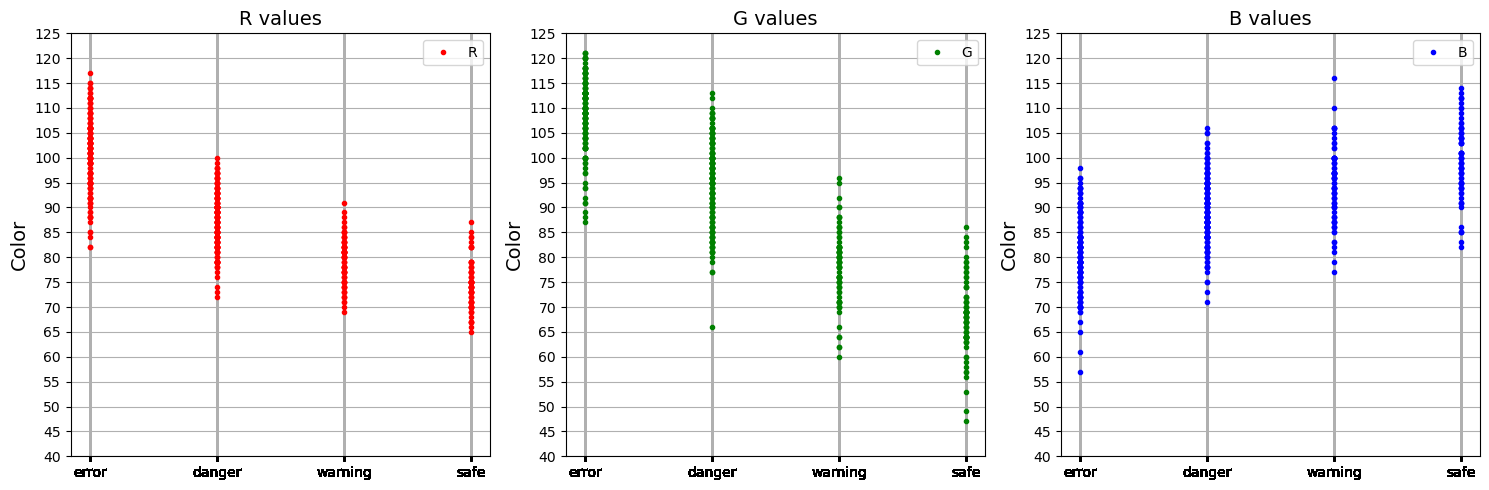

In [34]:
import matplotlib.pyplot as plt

# Plotting the RGB values
plt.figure(figsize=(15, 5))

# Plot for R values
plt.subplot(131)  # 1 row, 3 columns, plot in the first position
plt.plot(judge_values, R_values, marker='.', linestyle='', color='red', label='R')
plt.ylabel('Color', fontsize=14)
plt.title('R values', fontsize=14)
plt.grid(True)
plt.xticks(judge_values)
plt.yticks(range(40, 130, 5))
plt.legend()

# Plot for G values
plt.subplot(132)  # 1 row, 3 columns, plot in the second position
plt.plot(judge_values, G_values, marker='.', linestyle='', color='green', label='G')
plt.ylabel('Color', fontsize=14)
plt.title('G values', fontsize=14)
plt.grid(True)
plt.xticks(judge_values)
plt.yticks(range(40, 130, 5))
plt.legend()

# Plot for B values
plt.subplot(133)  # 1 row, 3 columns, plot in the third position
plt.plot(judge_values, B_values, marker='.', linestyle='', color='blue', label='B')
plt.ylabel('Color', fontsize=14)
plt.title('B values', fontsize=14)
plt.grid(True)
plt.xticks(judge_values)
plt.yticks(range(40, 130, 5))
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()

# Save the plot
output_filename = "output.png"
output_filepath = os.path.join(folder_path, output_filename)
plt.savefig(output_filepath)
plt.show()


### 결정경계 시각화 

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import numpy as np

#X_all = np.vstack([X_train_robust, X_valid_robust, X_test_robust])
X_all = np.vstack([X_train, X_valid, X_test])
y_all = np.concatenate([y_train, y_valid, y_test])

# LabelEncoder를 사용하여 클래스 레이블을 숫자로 변환
le = LabelEncoder()
y_encoded = le.fit_transform(y_all)

# 3D 플로팅을 위한 RGB 색상값 선택
rgb_colors = X_all[:, :3]

# 3D 플로팅 설정
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


x_min, x_max = rgb_colors[:, 0].min() - 1, rgb_colors[:, 0].max() + 1
y_min, y_max = rgb_colors[:, 1].min() - 1, rgb_colors[:, 1].max() + 1
z_min, z_max = rgb_colors[:, 2].min() - 1, rgb_colors[:, 2].max() + 1
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1),
                         np.arange(z_min, z_max, 0.1))

# 예측을 위해 그리드의 각 점에 모델을 적용
mesh_input = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
mesh_output = best_svm.predict(mesh_input)  # 여기서 모델은 학습된 모델로 대체해야 함

# 결과를 3D로 변환하여 등고선으로 표시
mesh_output = le.inverse_transform(mesh_output.argmax(axis=1))
mesh_output = mesh_output.reshape(xx.shape)

# 3D 플로팅 설정
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


# 사용자 정의 컬러맵 정의
custom_cmap = {'danger': 'r', 'warning': 'orange', 'safe': 'g', 'error': 'gray'}
legend_labels = le.inverse_transform(list(set(y_encoded)))
# 결정 경계 플로팅
for label in legend_labels:
    # 색상을 지정하여 점 플로팅
    scatter = ax.scatter(rgb_colors[y_encoded == le.transform([label])[0], 0],
                         rgb_colors[y_encoded == le.transform([label])[0], 1],
                         rgb_colors[y_encoded == le.transform([label])[0], 2],
                         label=label, c=custom_cmap[label],edgecolors='black', s=50)
   
    
   
ax.contourf(xx, yy, zz, mesh_output, cmap=plt.cm.RdYlBu, alpha=0.3)


# 클래스 레이블을 숫자로 변환한 것을 해독하여 색상 막대 추가
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=custom_cmap[label], markersize=13) for label in legend_labels]
ax.legend(handles=legend_handles)

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

ax.set_title('Detection GERD through RGB',fontsize=18)

# Save the plot
output_filename = "3D_Decision_Boundary.jpg"
output_filepath = os.path.join(folder_path, output_filename)
plt.savefig(output_filepath)
# 플로팅 표시

plt.show()
